### Import Libraries

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Split Dataset

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

In [3]:
train_x = train['X'].copy()
train_y = train['y'].copy()
test_x = test['X'].copy()
test_y = test['y'].copy()

train_x.shape, test_x.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [4]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

### Visualise dataset

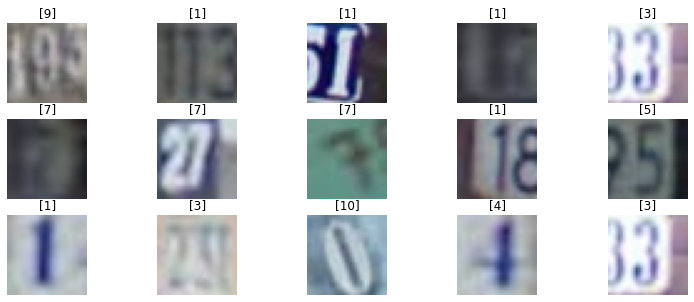

In [5]:
rows = 3
cols = 5
fig, ax = plt.subplots(3, 5, figsize=(13,5))
for i in range(rows):
    for j in range(cols):
        i_rand = np.random.randint(0,1000)
        ax[i][j].set_title(str(train_y[i_rand]))
        ax[i][j].set_axis_off()
        ax[i][j].imshow(train_x[:,:,:,i_rand])


In [6]:
x_train_gray = train_x.mean(axis=2, keepdims=True)
x_test_gray = test_x.mean(axis=2, keepdims=True)

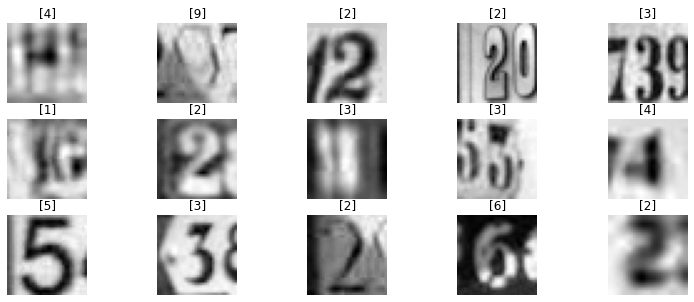

In [7]:
rows = 3
cols = 5
fig, ax = plt.subplots(3, 5, figsize=(13,5))
for i in range(rows):
    for j in range(cols):
        i_rand = np.random.randint(5,1000)
        ax[i][j].set_title(str(train_y[i_rand]))
        ax[i][j].set_axis_off()
        ax[i][j].imshow(x_train_gray[:,:,:,i_rand], cmap='gray')

### Build MLP Model

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import Regularizer

In [9]:
def build_model(input_shape):

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax', name='output'))

    return model

In [10]:
def compile_model(model):
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

In [11]:
checkpoint_path = 'checkpoints/checkpoint_{epoch:03d}'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss',
                                    verbose=1,
                                    save_weights_only=True)

call_off = EarlyStopping(monitor='val_accuracy', patience=4)

In [12]:
input_shape = x_train_gray[:,:,:,0].shape
model = build_model(input_shape)
model.summary()

2022-02-04 19:05:58.573183: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 11)                715       
Total params: 370,059
Trainable params: 370,059
Non-trainable params: 0
__________________________________________________

In [13]:
compile_model(model)
history = model.fit(np.moveaxis(x_train_gray,-1,0), train_y, epochs=15, validation_data=(np.moveaxis(x_test_gray,-1,0), test_y),
            callbacks=[call_off, model_checkpoint])

2022-02-04 09:28:37.032636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 300060672 exceeds 10% of free system memory.
2022-02-04 09:28:37.248614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
2281/2290 [============================>.] - ETA: 0s - loss: 2.8747 - accuracy: 0.3089

2022-02-04 09:28:49.094722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 106627072 exceeds 10% of free system memory.


2290/2290 [==============================] - 14s 6ms/step - loss: 2.8699 - accuracy: 0.3096 - val_loss: 1.6925 - val_accuracy: 0.4539

Epoch 00001: saving model to checkpoints/checkpoint_001
Epoch 2/15
2290/2290 [==============================] - 13s 6ms/step - loss: 1.4263 - accuracy: 0.5393 - val_loss: 1.7310 - val_accuracy: 0.4596

Epoch 00002: saving model to checkpoints/checkpoint_002
Epoch 3/15
2290/2290 [==============================] - 13s 6ms/step - loss: 1.2910 - accuracy: 0.5914 - val_loss: 1.3370 - val_accuracy: 0.5832

Epoch 00003: saving model to checkpoints/checkpoint_003
Epoch 4/15
2290/2290 [==============================] - 13s 6ms/step - loss: 1.2114 - accuracy: 0.6197 - val_loss: 1.2547 - val_accuracy: 0.6134

Epoch 00004: saving model to checkpoints/checkpoint_004
Epoch 5/15
2290/2290 [==============================] - 14s 6ms/step - loss: 1.1570 - accuracy: 0.6378 - val_loss: 1.2291 - val_accuracy: 0.6208

Epoch 00005: saving model to checkpoints/checkpoint_005
E

### Visualise Accuracy and Loss

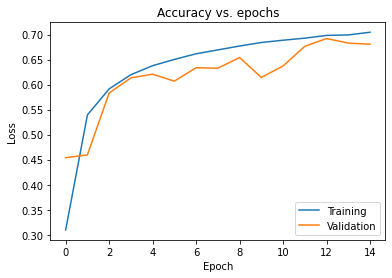

In [14]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

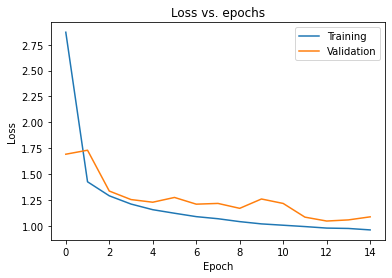

In [15]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### Build Convulutional Neural Network (CNN)

In [37]:
def conv_model(input_shape):
    kernel_size = 3
    pool_size = 2
    filters = 64
    num_labels = 11
    model_2 = keras.Sequential()
    model_2.add(keras.layers.Conv2D(filters=filters,
                                    kernel_size=kernel_size,
                                    input_shape=input_shape,
                                    activation='relu'))
    model_2.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model_2.add(keras.layers.BatchNormalization())
    model_2.add(keras.layers.Conv2D(filters=filters,
                                    kernel_size=kernel_size,
                                    activation='relu'))
    model_2.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    #model_2.add(keras.layers.Dropout(0.2))
    model_2.add(keras.layers.Conv2D(filters=filters,
                                    kernel_size=kernel_size,
                                    activation='relu'))
    model_2.add(keras.layers.Flatten())
    model_2.add(keras.layers.Dense(units=num_labels, activation='softmax'))
    
    return model_2

In [38]:
model_2 = conv_model(input_shape)
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

In [39]:
checkpoint_path = 'checkpoint_conv/checkpoint_{epoch:03d}'
model_checkpoint_2 = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss',
                                   save_best_only=True,
                                    verbose=1,
                                    save_weights_only=True)

call_off_2 = EarlyStopping(monitor='val_accuracy', patience=3)

In [40]:
compile_model(model_2)
history = model_2.fit(np.moveaxis(x_train_gray,-1,0), train_y, epochs=7, validation_data=(np.moveaxis(x_test_gray,-1,0), test_y),
            callbacks=[call_off_2, model_checkpoint_2])

Epoch 1/7
2290/2290 [==============================] - 144s 63ms/step - loss: 0.6144 - accuracy: 0.8152 - val_loss: 0.5308 - val_accuracy: 0.8387

Epoch 00001: val_loss improved from inf to 0.53080, saving model to checkpoint_conv/checkpoint_001
Epoch 2/7
2290/2290 [==============================] - 145s 63ms/step - loss: 0.3930 - accuracy: 0.8846 - val_loss: 0.4973 - val_accuracy: 0.8529

Epoch 00002: val_loss improved from 0.53080 to 0.49734, saving model to checkpoint_conv/checkpoint_002
Epoch 3/7
2290/2290 [==============================] - 143s 62ms/step - loss: 0.3426 - accuracy: 0.8989 - val_loss: 0.4066 - val_accuracy: 0.8839

Epoch 00003: val_loss improved from 0.49734 to 0.40658, saving model to checkpoint_conv/checkpoint_003
Epoch 4/7
2290/2290 [==============================] - 156s 68ms/step - loss: 0.3126 - accuracy: 0.9093 - val_loss: 0.4084 - val_accuracy: 0.8838

Epoch 00004: val_loss did not improve from 0.40658
Epoch 5/7
2290/2290 [==============================] - 1

### Visualise Accuracy and Loss

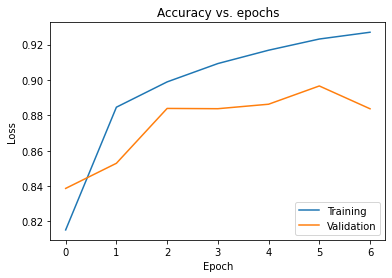

In [41]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

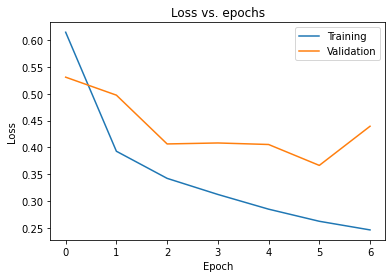

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### Make Prediction on Both Models

In [43]:
mlp_model = build_model(input_shape)
conv_model = conv_model(input_shape)

In [17]:
x_test_axis = np.moveaxis(x_test_gray, -1, 0)

In [18]:
compile_model(mlp_model)
mlp_model.evaluate(x_test_axis, test_y)
mlp_model.load_weights(tf.train.latest_checkpoint('checkpoints'))
mlp_model.evaluate(x_test_axis, test_y)

2022-02-04 19:06:24.612685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


814/814 [==============================] - 2s 3ms/step - loss: 1.0879 - accuracy: 0.6807


[1.0879427194595337, 0.6806622743606567]

In [44]:
compile_model(conv_model)
conv_model.evaluate(x_test_axis, test_y)
conv_model.load_weights(tf.train.latest_checkpoint('checkpoint_conv'))
conv_model.evaluate(x_test_axis, test_y)

814/814 [==============================] - 13s 16ms/step - loss: 0.3667 - accuracy: 0.8966


[0.3666699528694153, 0.8966272473335266]

In [19]:
mlp_pred = mlp_model.predict(x_test_axis[0:5])

### Visual Comparison

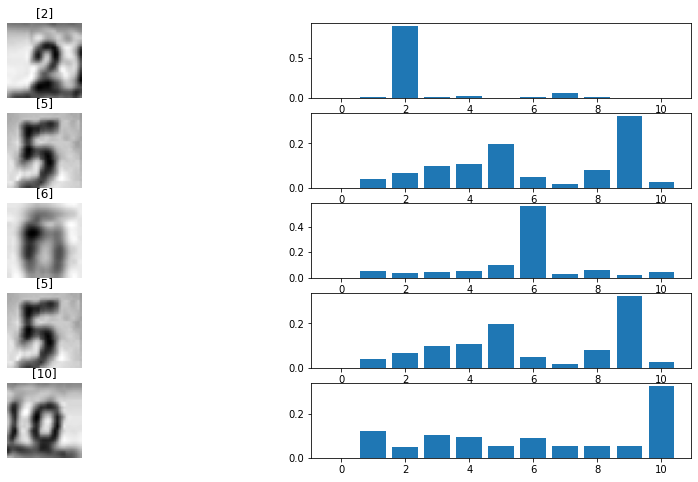

In [35]:
rows = 5
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15,8))
random_number = []
for i in range(rows):
    i_rand = np.random.randint(0,5)
    random_number.append(i_rand)
    ax[i][0].set_title(str(test_y[i_rand]))
    #plt.bar([0,1,2,3,4,5,6,7,8,9,10], mlp_pred[0])
    ax[i][0].set_axis_off()
    ax[i][0].imshow(x_test_gray[:,:,:,i_rand], cmap='gray')
    ax[i][1].bar([0,1,2,3,4,5,6,7,8,9,10], mlp_pred[i_rand])

In [45]:
conv_pred = conv_model.predict(x_test_axis[0:5])

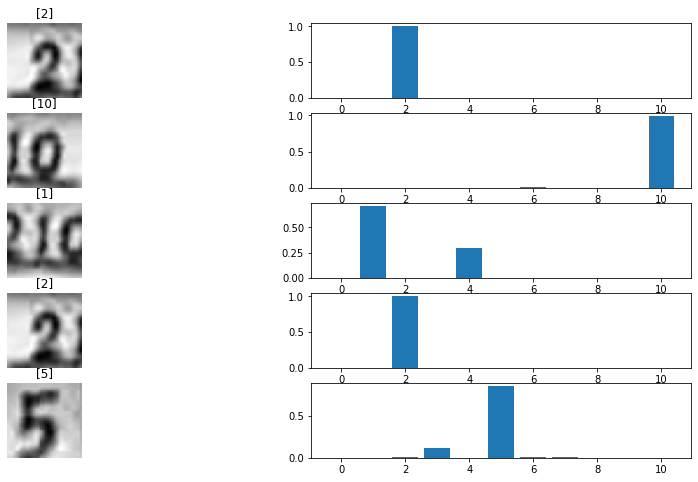

In [46]:
rows = 5
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15,8))
random_number = []
for i in range(rows):
    i_rand = np.random.randint(0,5)
    random_number.append(i_rand)
    ax[i][0].set_title(str(test_y[i_rand]))
    ax[i][0].set_axis_off()
    ax[i][0].imshow(x_test_gray[:,:,:,i_rand], cmap='gray')
    ax[i][1].bar([0,1,2,3,4,5,6,7,8,9,10], conv_pred[i_rand])

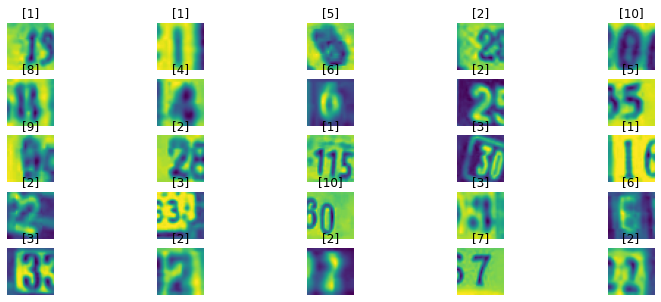

In [47]:
rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(13,5))
random_number = []
for i in range(rows):
    for j in range(cols):
        i_rand = np.random.randint(5,1000)
        random_number.append(i_rand)
        ax[i][j].set_title(str(test_y[i_rand]))
        ax[i][j].set_axis_off()
        ax[i][j].imshow(x_test_gray[:,:,:,i_rand])

In [24]:
pred_mlp = mlp_model.predict(x_test_axis)
pred_conv = conv_model.predict(x_test_axis)

### Comparison by Distribution

In [25]:
def prediction_class(logits):
    prediction_list = []
    for l in logits:
        pred_index = l.argmax()
        prediction_list.append(pred_index)
    return prediction_list

def plot_distribution(prediction_list, title):
    df = pd.DataFrame({'predictions': prediction_list})
    val_count = df['predictions'].value_counts()
    plt.bar(list(val_count.keys()), val_count.values)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Class Frequency')
    plt.title(title)
    plt.show()

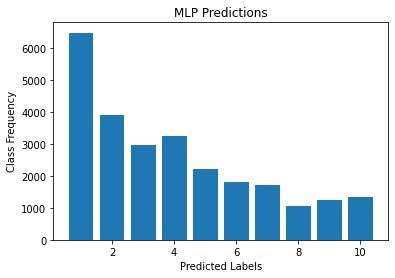

In [26]:
prediction_list = prediction_class(pred_mlp)
plot_distribution(prediction_list, 'MLP Predictions')

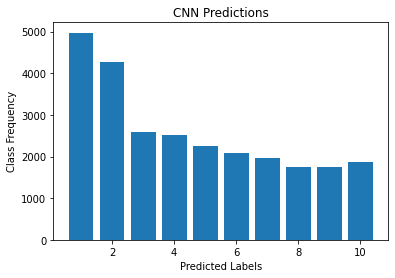

In [27]:
prediction_list = prediction_class(pred_conv)
plot_distribution(prediction_list, 'CNN Predictions')

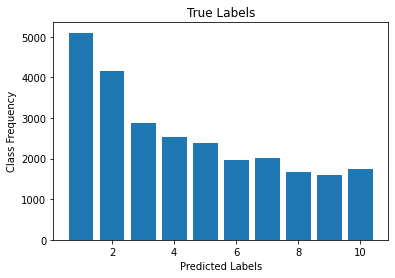

In [28]:
plot_distribution(tf.squeeze(test_y), 'True Labels')